## Observability Checker for White Dwarfs (or any other target with a Gaia ID or RA/dec)

To-do list:
- Figure out a way to speed it up
- Improve observability constraint
- Consider Moon contamination
- Make the plotting look better
- Make the filtering/sorting better and improve the ease of use

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, AltAz, SkyCoord, get_sun
from astropy.time import Time
import astropy.units as u
from datetime import datetime, timedelta
import pytz
from astroquery.vizier import Vizier
import pandas as pd
import sys
pd.options.mode.copy_on_write = True

def grab_gaia_coords_and_mag(gaia_id):
    '''
    Collects RA, Dec, and apparent Gaia G magnitude for a given Gaia DR3 id. INTERNET REQUIRED.

    Params
    -------
    gaia_id: integer containing the Gaia DR3 id of the target. Ex: 3088536756653876352

    Returns
    -------
    target_ra: The target's right ascension in degrees
    target_dec: The target's declination in degrees
    target_gmag: The target's apparent Gaia G magnitude
    '''

    columns = ['Source', 'RA_ICRS', 'DE_ICRS', 'Gmag']
    Vizier_search = Vizier(columns=columns)
    result = Vizier_search.query_object(f'Gaia DR3 {gaia_id}', catalog='I/355/gaiadr3', radius=2 * u.arcsec)

    if len(result) > 0:
        result_table = result[0]
        if len(result_table) > 1:
            print(f'WARNING: {len(result_table)} targets within cone around Gaia DR3 {gaia_id}. Choosing the closest target to the given coordinates.')
        target = result_table[0]
        target_ra = target['RA_ICRS']
        target_dec = target['DE_ICRS']
        target_gmag = target['Gmag']
        return target_ra, target_dec, target_gmag
    else:
        print(f'WARNING: No targets found within 2" of Gaia DR3 {gaia_id}. Skipping this target.')
        return None, None, None

def compute_airmass(ra, dec, latitude, longitude, date, elevation=0, timezone='America/Detroit', plot=False):
    '''
    Determines the local sunrise and sunset times for a given date and computes a given target's airmass over that night.

    Params
    -------
    ra: The target's right ascension in degrees
    dec: The target's declination in degrees
    latitude: The observatory's latitude in degrees (North is positive)
    longitude: The observatory's longitude in degrees (East is positive)
    date: The local evening date to compute the airmass of the target in the format MM-DD-YYYY
    elevation: The elevation of the observatory (using astropy units; default = sea level). Ex: 450 * u.ft
    timezone: The time zone of the observatory. List of timezones: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
    plot: A boolean for whether or not the airmass is plotted

    Returns
    -------
    observable: A boolean for whether or not the target meets the observability constraints
    set_time: The local time that the observatory sets below 20 degrees (2.8 airmass)
    '''

    # Observer's location
    location = EarthLocation(lat=latitude, lon=longitude, height=elevation)
    
    # Define the date in local timezone
    local_tz = pytz.timezone(timezone)  # Change to your timezone

    # Parse the input date and determine local noon on the date
    local_date = datetime.strptime(date, '%m-%d-%Y')
    local_noon_start = local_tz.localize(local_date + timedelta(hours=12))  # Noon on input date

    # Convert to UTC for astropy
    utc_start = local_noon_start.astimezone(pytz.UTC)

    # Generate a full day of time points (in UTC)
    times = Time([utc_start + timedelta(minutes=5 * i) for i in range(24*12)]) # one point every 5 min
    sun_altaz = get_sun(times).transform_to(AltAz(obstime=times, location=location))
    sun_altitudes = sun_altaz.alt.deg

    # Find sunset and sunrise indices
    sunset_idx = np.where((sun_altitudes[:-1] > 0) & (sun_altitudes[1:] <= 0))[0]
    sunrise_idx = np.where((sun_altitudes[:-1] <= 0) & (sun_altitudes[1:] > 0))[0]

    # Handle cases where sunset or sunrise is missing
    if len(sunset_idx) == 0 or len(sunrise_idx) == 0:
        raise ValueError('Sunset or sunrise times could not be determined. Check the location and date.')

    # Select the first sunset and the next sunrise
    sunset_time = times[sunset_idx[0]]
    sunrise_time = times[sunrise_idx[0]]

    # Generate time range from sunset to sunrise
    night_times = Time([sunset_time + timedelta(minutes=i) for i in range(int((sunrise_time - sunset_time).sec // 60) + 1)])

    # Convert time to local time for plotting
    local_times = night_times.to_datetime(timezone=local_tz)

    # Target coordinates
    target = SkyCoord(ra=ra, dec=dec, unit='deg')
    
    # AltAz frame for the times
    altaz_frame = AltAz(obstime=night_times, location=location)
    target_altaz = target.transform_to(altaz_frame)
    airmass = target_altaz.secz

    # Filter valid airmass values between an airmass of 2.8 and 1
    valid = (airmass > 1) & (airmass < 2.8)

    observable_times = [local_times[i] for i in range(len(local_times)) if valid[i]]
    observable_airmass = airmass[valid]

    if len(observable_times) > 36: # if the target is observable for >3 hrs
        observable=True
        set_time = observable_times[-1]
    else:
        observable=False
        set_time = None

    # Plot the airmass
    if plot==True:
        plt.figure(figsize=(10, 6))
        plt.plot(observable_times, observable_airmass, label='Target Airmass', color='k')
        plt.axhline(2.8, color='red', linestyle='--', label='Airmass = 2.8 (Horizon Limit)') # altitude of 20 deg
        plt.gca().invert_yaxis()  # airmass and altitude are inversely proportional
        plt.xlabel(f'Local Time ({timezone})')
        plt.ylabel('Airmass')
        plt.ylim(3, 1)
        plt.title(f'Airmass Plot for Target ({ra}°, {dec}°) on {date}')
        plt.axvline(local_times[0], color='orange', linestyle='-', label='Sunset')
        plt.axvline(local_times[-1], color='green', linestyle='-', label='Sunrise')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
    
    return observable, set_time

def grab_all_gaia_info(file, outputfile='wd_positions.txt'):
    '''
    Reads in a list of gaia DR3 ids from a file and creates a new file with the gaia coordinates and magnitudes included. INTERNET REQUIRED.

    Params
    -------
    file: The path to the file containing a whitespace delimited list of Gaia DR3 ids
    outputfile: The path of the output file.

    Returns
    -------
    A space-separated text file containing the Gaia ID, RA (degrees), Dec (degrees), and Gmag
    '''

    target_list = pd.read_csv(file, delim_whitespace=True, names=['gaia_id'])
    ra_list = []
    dec_list = []
    gmag_list = []
    for gaia_id in target_list.gaia_id:
        ra, dec, gmag = grab_gaia_coords_and_mag(gaia_id)
        ra_list.append(ra)
        dec_list.append(dec)
        gmag_list.append(gmag)
    target_list['ra'] = ra_list
    target_list['dec'] = dec_list
    target_list['gmag'] = gmag_list
    target_list.to_csv(outputfile, index=False, sep=' ')

def check_observability_and_sort(file, latitude, longitude, date, elevation=0, timezone='America/Detroit', grab_gaia = True,
                                 outpath='.'):
    '''
    Reads in a list of gaia DR3 ids from a file, checks the observability of each target, and then creates a sorted list of observable targets. INTERNET REQUIRED if grab_gaia = True.

    Params
    -------
    file: The path to the file containing a whitespace delimited list of Gaia DR3 ids
    latitude: The observatory's latitude in degrees (North is positive)
    longitude: The observatory's longitude in degrees (East is positive)
    date: The local evening date to compute the airmass of the target in the format MM-DD-YYYY
    elevation: The elevation of the observatory (using astropy units; default = sea level). Ex: 450 * u.ft
    timezone: The time zone of the observatory. List of timezones: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
    grab_gaia: A boolean for whether or not a gaia query is run for each target to grab its coordinates and G magnitude
    outpath: The directory to place the output file

    Returns
    -------
    A CSV containing the observable targets, their RA/Dec, apparent Gaia G magnitude, and the time that it rises and sets. If the target doesn't
    rise or set after sunset or before sunrise, the listed rise time or set time will be the sunset or sunrise.
    '''

    if grab_gaia == True:
        target_list = pd.read_csv(file, delim_whitespace=True, names=['gaia_id'])
    else:
        target_list = pd.read_csv(file, delim_whitespace=True, names=['gaia_id', 'ra', 'dec', 'gmag'], header=0)

    observable_list = []
    gmag_list = []
    set_time_list = []
    ra_list = []
    dec_list = []
    skip_list = [] # list of id indices that are being skipped
    i = 1 # counter for progress tracking
    maxi = len(target_list.gaia_id)
    for j in range(len(target_list.gaia_id)):
        if grab_gaia==True:
            ra, dec, gmag = grab_gaia_coords_and_mag(target_list.gaia_id[j])
        else:
            ra, dec, gmag = target_list.ra[j], target_list.dec[j], target_list.gmag[j]
        if ra == None:
            skip_list.append(i - 1)
            i += 1
            continue
        observable, set_time = compute_airmass(ra=ra, dec=dec, latitude=latitude, longitude=longitude, date=date, elevation=elevation, timezone=timezone)
        observable_list.append(observable)
        gmag_list.append(gmag)
        set_time_list.append(set_time)
        ra_list.append(ra)
        dec_list.append(dec)
        sys.stdout.write(f'\rChecking observability of target {i} out of {maxi}. {round(i/maxi*100, 1)}%') # progress updates
        sys.stdout.flush()
        i += 1
        
    target_list.drop(skip_list, inplace=True)
    target_list['observable'] = observable_list
    target_list['RA'] = ra_list
    target_list['Dec'] = dec_list
    target_list['Gmag'] = gmag_list
    target_list['set_time'] = set_time_list
    observable_target_list = target_list.loc[target_list.observable, :]
    observable_target_list.sort_values('Gmag', ascending=True, inplace=True)
    observable_target_list.to_csv(f'{outpath}/observable_target_list_{date}.csv', columns=['gaia_id', 'RA', 'Dec', 'Gmag', 'set_time'], index=False)
    

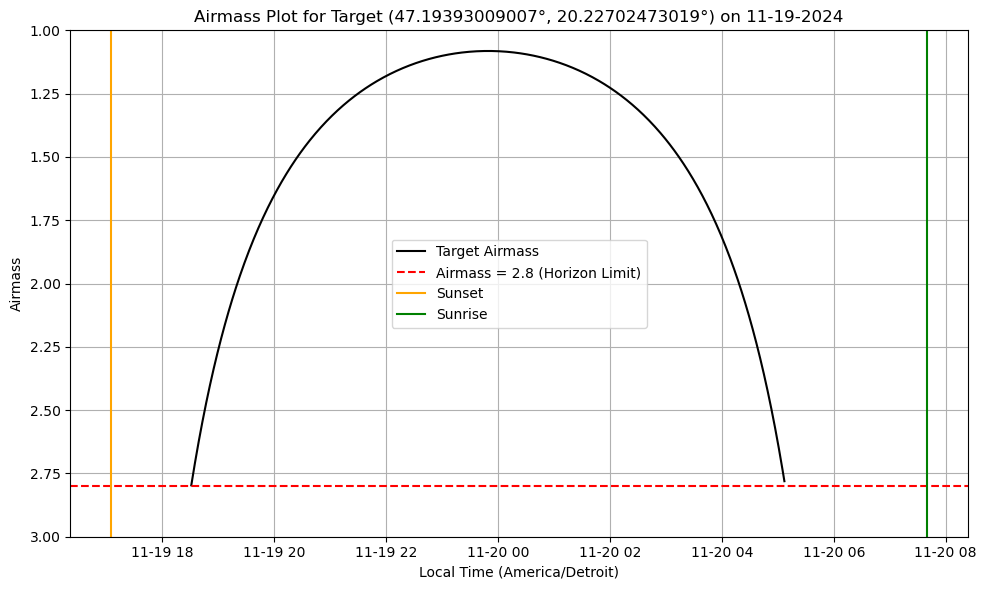

(True,
 datetime.datetime(2024, 11, 20, 5, 7, tzinfo=<DstTzInfo 'America/Detroit' EST-1 day, 19:00:00 STD>))

In [118]:
path='/Users/jack/Research/work_for_collabs/wdbinaries_mets.txt'
data = pd.read_csv(path, delim_whitespace=True, names=['gaia_id'])
ra, dec, gmag = grab_gaia_coords_and_mag(data.gaia_id[0])
compute_airmass(ra, dec, 42.7063, -84.4834, '11-19-2024', plot=True)


In [113]:
path='/Users/jack/Research/work_for_collabs/wdbinaries_all.txt'
output_path = '/Users/jack/Research/work_for_collabs/wdbinaries_all_positions.txt'
grab_all_gaia_info(path, output_path)

In [ ]:
path='/Users/jack/Research/work_for_collabs/wdbinaries_all_positions.txt'
target_df = check_observability_and_sort(path, 42.7063, -84.4834, '12-2-2024', grab_gaia=False)

Checking observability of target 1510 out of 2277. 66.3%

/Users/jack/opt/anaconda3/envs/research/lib/python3.10/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/Users/jack/opt/anaconda3/envs/research/lib/python3.10/site-packages/erfa/core.py:19026: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/Users/jack/opt/anaconda3/envs/research/lib/python3.10/site-packages/erfa/core.py:4058: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq(ri, di, astrom)


Checking observability of target 2277 out of 2277. 100.0%